https://www.analyticsvidhya.com/blog/2019/10/building-image-classification-models-cnn-pytorch/

https://towardsdatascience.com/how-to-train-an-image-classifier-in-pytorch-and-use-it-to-perform-basic-inference-on-single-images-99465a1e9bf5


In [2]:
import torch
from IPython.display import Image, clear_output 

print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

PyTorch 1.5.0+cu101 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


In [0]:
# !git clone https://github.com/praveenraghuvanshi1512/janatahack.git

In [4]:
# Load data from Google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
cd '/content/drive/My Drive/jantahackathon/data'

/content/drive/My Drive/jantahackathon/data


In [6]:
!ls

full  images  test_vc2kHdQ.csv	train.csv  train_SOaYf6m.zip


In [7]:
!pip install ipython-autotime
%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=54efe353997f4ab9f14474347f098955ee6c295433b2ae3fdd5ef40555b5168c
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


In [8]:
# Constants
TEST_CSV = '/content/drive/My Drive/jantahackathon/data/test_vc2kHdQ.csv'

TRAIN_CSV = '/content/drive/My Drive/jantahackathon/data/train.csv'
TOTAL_IMAGES_PATH = '/content/drive/My Drive/jantahackathon/data/full'
TOTAL_IMAGES_EMERGENCY_PATH = '/content/drive/My Drive/jantahackathon/data/full/emergency'
TOTAL_IMAGES_NOT_EMERGENCY_PATH = '/content/drive/My Drive/jantahackathon/data/full/notemergency'
TRAIN_ZIP = '/content/drive/My Drive/jantahackathon/data/train_SOaYf6m.zip'
ALL_IMAGES_PATH = '/content/drive/My Drive/jantahackathon/data/images'

time: 3.05 ms


In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

from skimage.io import imread
from tqdm import tqdm

%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models

time: 9.44 ms


In [10]:
test_dataframe = pd.read_csv(TEST_CSV)

time: 292 ms


In [11]:
test_dataframe.head()

,image_names
0,1960.jpg
1,668.jpg
2,2082.jpg
3,808.jpg
4,1907.jpg


time: 20.1 ms


In [12]:
test_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 706 entries, 0 to 705
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_names  706 non-null    object
dtypes: object(1)
memory usage: 5.6+ KB
time: 4 ms


In [13]:
#!unzip '/content/drive/My Drive/jantahackathon/data/train_SOaYf6m.zip' -d .

time: 577 µs


In [12]:
all_images = os.listdir(ALL_IMAGES_PATH)
print('Total images: ', len(all_images))

Total images:  2352
time: 34.9 s


In [14]:
train_dataframe = pd.read_csv(TRAIN_CSV)

time: 398 ms


In [15]:
train_dataframe.head()

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


time: 9.56 ms


In [16]:
train_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646 entries, 0 to 1645
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   image_names       1646 non-null   object
 1   emergency_or_not  1646 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 25.8+ KB
time: 4.85 ms


In [0]:
'''import shutil 

for row in train_dataframe.itertuples():
  img_name = row.image_names
  emergency_or_not = row.emergency_or_not
  source = ALL_IMAGES_PATH + '/' + str(img_name)
  if emergency_or_not == 1:   
    destination = TRAIN_IMAGES_EMERGENCY_PATH + '/' + str(img_name)
  if emergency_or_not == 0:   
    destination = TRAIN_IMAGES_NOT_EMERGENCY_PATH + '/' + str(img_name)
  
  dest = shutil.copyfile(source, destination)
  print(dest) '''


In [18]:
print(len(os.listdir(TOTAL_IMAGES_EMERGENCY_PATH)))
print(len(os.listdir(TOTAL_IMAGES_NOT_EMERGENCY_PATH)))

681
965
time: 14.2 s


In [19]:
data_dir = TOTAL_IMAGES_PATH
def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([transforms.ToTensor(),
                                       ])
    test_transforms = transforms.Compose([transforms.ToTensor(),
                                      ])
    train_data = datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    test_data = datasets.ImageFolder(datadir,
                    transform=test_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=16)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=16)
    return trainloader, testloader
trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)

['emergency', 'notemergency']
time: 50.6 ms


In [20]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def display(noofimages, trainloader, classes):
    # get some random training images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()
    maximagescount = labels.size()[0]
    print(maximagescount)
    print(len(images))
    if noofimages > maximagescount:
        raise ValueError('The no of images must be less than ' + maximagescount)

    # show images
    imshow(torchvision.utils.make_grid(images[:5]))

    # display labels
    print(' '.join('%5s' % classes[labels[j]] for j in range(noofimages)))

time: 11.3 ms


16
16
notemergency emergency emergency notemergency notemergency


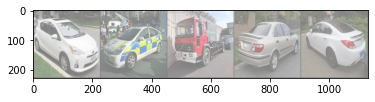

time: 5.41 s


In [21]:
# Display train samples
display(5, trainloader, trainloader.dataset.classes)

16
16
emergency emergency notemergency notemergency notemergency


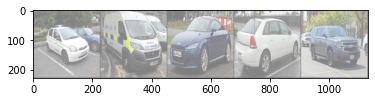

time: 4.26 s


In [22]:
# Display Test samples
display(5, testloader, testloader.dataset.classes)

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
model = models.resnet50(pretrained=True)
print(model)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

In [26]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 2),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

time: 9.43 s


In [29]:
epochs = 1
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []
for epoch in tqdm(range(epochs)):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
torch.save(model, 'jantahackathon.pth')

Epoch 1/1.. Train loss: 2.684.. Test loss: 0.869.. Test accuracy: 0.579
Epoch 1/1.. Train loss: 0.632.. Test loss: 0.627.. Test accuracy: 0.598
Epoch 1/1.. Train loss: 0.551.. Test loss: 0.440.. Test accuracy: 0.846
Epoch 1/1.. Train loss: 0.385.. Test loss: 0.312.. Test accuracy: 0.875
Epoch 1/1.. Train loss: 0.282.. Test loss: 0.297.. Test accuracy: 0.870
Epoch 1/1.. Train loss: 0.300.. Test loss: 0.240.. Test accuracy: 0.923
Epoch 1/1.. Train loss: 0.272.. Test loss: 0.276.. Test accuracy: 0.885
Epoch 1/1.. Train loss: 0.471.. Test loss: 0.252.. Test accuracy: 0.903
time: 5min 45s


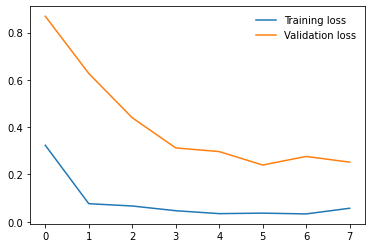

time: 203 ms


In [30]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [31]:
data_dir = TOTAL_IMAGES_PATH

test_transforms = transforms.Compose([transforms.ToTensor(),
                                      #transforms.Normalize([0.485, 0.456, 0.406],
                                      #                     [0.229, 0.224, 0.225])
                                     ])

time: 5.3 ms


In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('jantahackathon.pth')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

time: 189 ms


In [33]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

time: 2.22 ms


In [34]:
def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

time: 6.86 ms


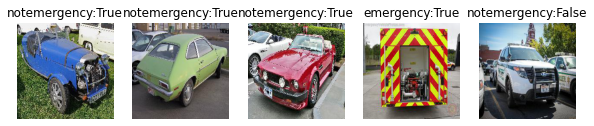

time: 286 ms


In [36]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(testloader.dataset.classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

In [0]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 8, kernel_size=3, stride=1, padding=1), # 224 -> 222
            BatchNorm2d(8),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),                 # 222 -> 111

            # Defining another 2D convolution layer
            Conv2d(8, 16, kernel_size=3, stride=1, padding=1), # 111 -> 109
            BatchNorm2d(16),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),                  # 109 -> 54

            # Defining another 2D convolution layer
            Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # 54 -> 52
            BatchNorm2d(32),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),                  # 52 -> 27

            # Defining another 2D convolution layer
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1), # 27 -> 25
            BatchNorm2d(128),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),                  # 25 -> 12

            # Defining another 2D convolution layer
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1), # 12 -> 10
            BatchNorm2d(32),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),                  # 10 -> 5
        )

        self.linear_layers = Sequential(
            Linear(4 * 5 * 5, 10)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [14]:
# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.07)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, 

In [0]:
# defining the number of epochs
n_epochs = 25
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
    train(epoch)

In [0]:
# plotting the training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()